# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Linear Decision Boundary Analysis](#Linear-Decision-Boundary-Analysis)
- [Problems](#Problems)
- [Solutions](#Solutions)
- [Tree Modeling](#Tree-Modeling)
- [Model Evaluation](#Model-evaluation)
- [Results](#Results)
- [Conclusion](#Conclusion)

## Introduction
### Binary Classification: Day 5 - Error Analysis
- This notebook focuses on Analyzing the Error using Decision Boundaries

## Importing Libraries

In [19]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.basic_cleaning import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [20]:
train_data = pl.read_csv("balanced_train.csv")
test_data = pl.read_csv("balanced_test.csv")
train_data.head()

SeniorCitizen,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,MonthlyCharges,TotalCharges,Streamer,Safer,Family,OnlinePayment,All,Churn
i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64
0,51,0,1,1,0,1,1,12,60.15,3077.0,1,1,1,0,1,0
0,5,0,2,0,0,0,0,12,20.1,85.1,0,0,1,0,0,0
0,28,0,0,0,0,0,0,1,81.05,2227.1,1,0,1,1,0,1
0,2,0,0,0,0,0,0,1,79.75,164.5,1,0,0,1,0,1
0,30,1,0,1,1,0,0,1,94.3,2679.7,1,1,0,0,0,0


In [21]:
from sklearn.pipeline import Pipeline

cat_cols=["SeniorCitizen","MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","Contract","Streamer","Safer","Family","OnlinePayment","All"]
num_cols=train_data.drop(["Churn","customerID"]+cat_cols).columns

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

import joblib
with open("pipe_smote.joblib",'rb'):
    pipe=joblib.load("pipe_smote.joblib")
pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('select', SelectKBest()),
                ('classifier',
                 LogisticRegression(C=0.11566740451422432, max_iter=1000,
                                    penalty='l1', random_state=42,
                                    solver='saga'))])

## Linear Decision Boundary Analysis

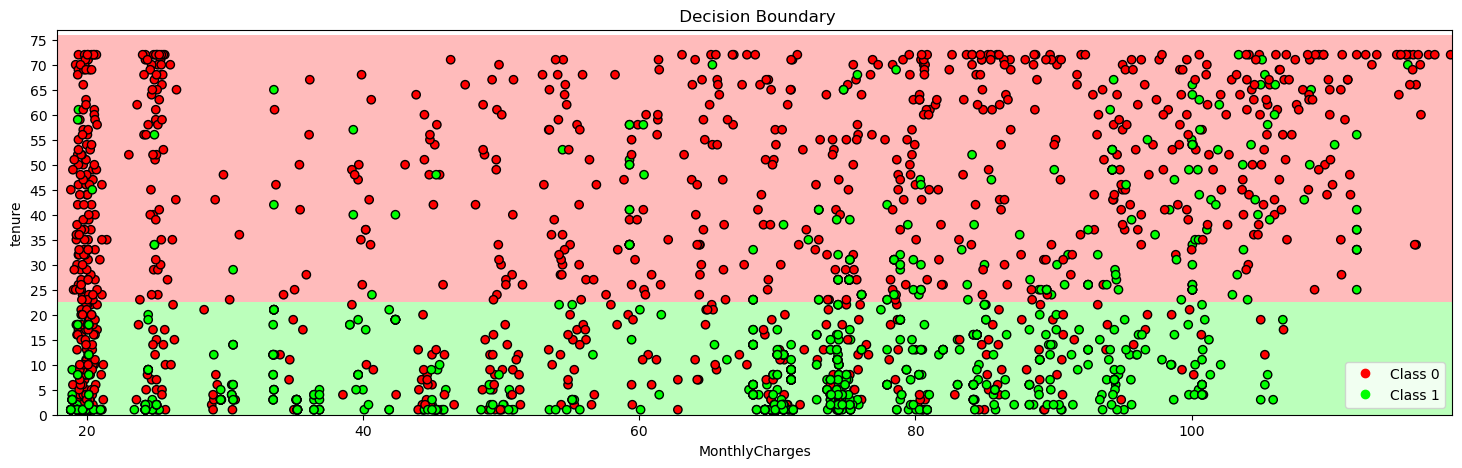

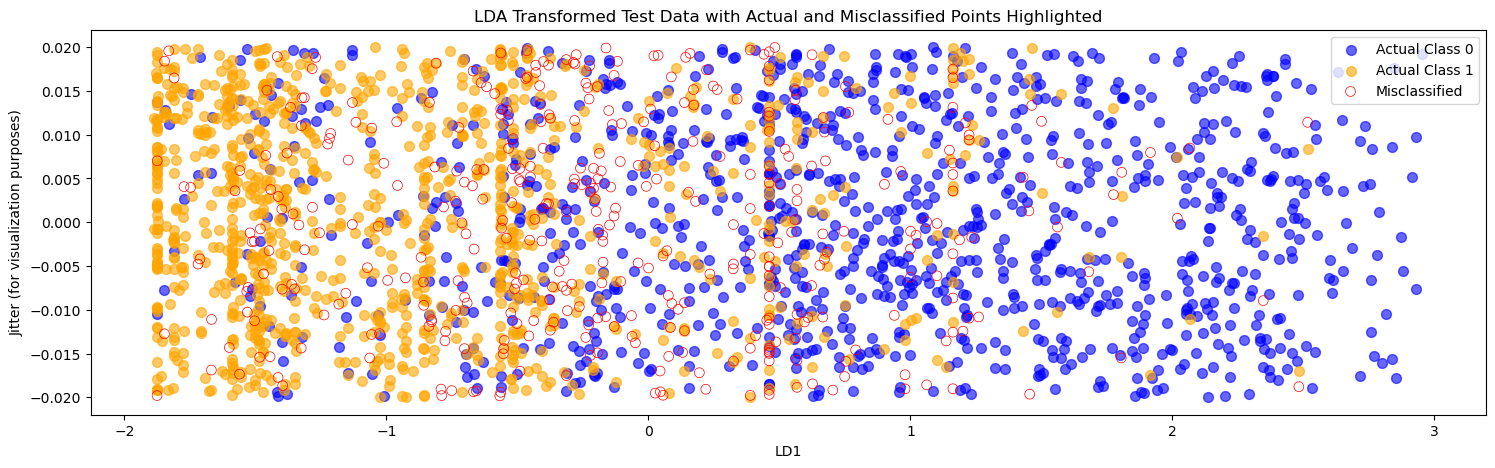

In [22]:
from sklearn.feature_selection import SelectKBest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

# Plotting decision boundary
classifier = pipe.named_steps['classifier']
transformer = Pipeline(steps=[("transformer",pipe.named_steps['transformer']),("select",SelectKBest(k=10))])
transformer.fit(X_train,y_train)# Select two features (example: 'MonthlyCharges' and 'Contract')
feature1 = 'MonthlyCharges'
feature2 = 'tenure'
decision_boundary(X_test,y_test,feature1,feature2,classifier,transformer) # User defined Function

# Creating LDA Plot of Class visualization

transformer = ColumnTransformer(transformers=
                                [
                                    ("num",StandardScaler(),num_cols)
                                ],remainder='passthrough')
lda_pipe = Pipeline(
    [
        ("transformer", transformer),
        ('select',SelectKBest()),
        ("classifier", LinearDiscriminantAnalysis()),
    ]
)
lda_pipe.fit(X_train,y_train)

from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_predict
rskf = RepeatedStratifiedKFold(n_splits=3,n_repeats=3,random_state=42)

predictions_prob= cross_val_predict(lda_pipe,X_test,y_test,method='predict_proba',n_jobs=-1)
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
X_train_lda=lda_pipe.transform(X_train)
X_test_lda=lda_pipe.transform(X_test)
# Creating the plot
plt.figure(figsize=(18, 5))
point_size = 50  # Adjust point size as needed
jitter = 0.02  # Adjust jitter as needed

for actual_class in [0, 1]:
    idx = (y_test == actual_class)
    jitter_values = np.random.uniform(-jitter, jitter, size=idx.sum())
    plt.scatter(X_test_lda[idx], jitter_values, 
                c='blue' if actual_class == 0 else 'orange', 
                label=f'Actual Class {actual_class}', alpha=0.6, s=point_size)

# Highlight misclassified points
misclassified_idx = (predictions != y_test)
misclassified_jitter = np.random.uniform(-jitter, jitter, size=misclassified_idx.sum())
plt.scatter(X_test_lda[misclassified_idx], misclassified_jitter, 
            facecolors='none', edgecolors='red', linewidths=0.5, label='Misclassified', s=point_size)

plt.title('LDA Transformed Test Data with Actual and Misclassified Points Highlighted')
plt.xlabel('LD1')
plt.ylabel('Jitter (for visualization purposes)')
plt.legend()
# plt.grid(axis='x')
plt.show()

## Problems
1) Some Observations are overlapping each other
2) Linear Decision Boundary Failing to fit Some Observations

## Solutions
1) Collecting More Information from users
2) Creating Non linear decision boundaries using
    - Polynomial Features
    - SVMs
    - Tree Based Models

- ### Polynomial Features and SVMs requires more manual feature engineering to get the desired boundary and takes Higher Computation resources

## Tree Modeling

In [23]:
from sklearn.model_selection import cross_val_predict, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, accuracy_score, recall_score, matthews_corrcoef, classification_report
from skopt import BayesSearchCV
from skopt.space import Real, Integer,Categorical
from sklearn.tree import DecisionTreeClassifier


# Assuming num_cols is defined with your numerical feature names
rskf = RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=42)

dt_clf = DecisionTreeClassifier(random_state=42)

param_distributions = {
  'criterion': Categorical(['gini', 'entropy']),
  'splitter': Categorical(['best', 'random']),  # Splitter strategy
  'max_depth': Integer(1, 50),  # Adjusted depth range
  'min_samples_split': Integer(2, 50),  # Adjusted split threshold
  'min_samples_leaf': Integer(1, 20),  # Adjusted leaf threshold
  'max_features': Real(0.1, 1.0),  # Feature selection proportion
  'ccp_alpha': Real(0.0, 0.5),  # Complexity control
}


search = BayesSearchCV(
    estimator=dt_clf,
    search_spaces=param_distributions,
    n_iter=100,
    cv=rskf,
    n_jobs=-1,
    random_state=42,
    scoring='roc_auc'
)

search.fit(X_train, y_train)
best_params = search.best_params_

dt_clf.set_params(**best_params)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=32, max_features=1.0, min_samples_leaf=18,
                       min_samples_split=50, random_state=42)

## Model Evaluation

Mean Train roc auc Score: 0.9324827474747475
Mean Train recall Score: 0.8465454545454546

Mean Test roc auc Score: 0.8909025381083562
Mean Test recall Score: 0.8164040404040405
Recall score: 0.79
Correlation: 0.5946086575832795
Classification Report
               precision    recall  f1-score   support

           0       0.79      0.80      0.80      1031
           1       0.80      0.79      0.80      1031

    accuracy                           0.80      2062
   macro avg       0.80      0.80      0.80      2062
weighted avg       0.80      0.80      0.80      2062



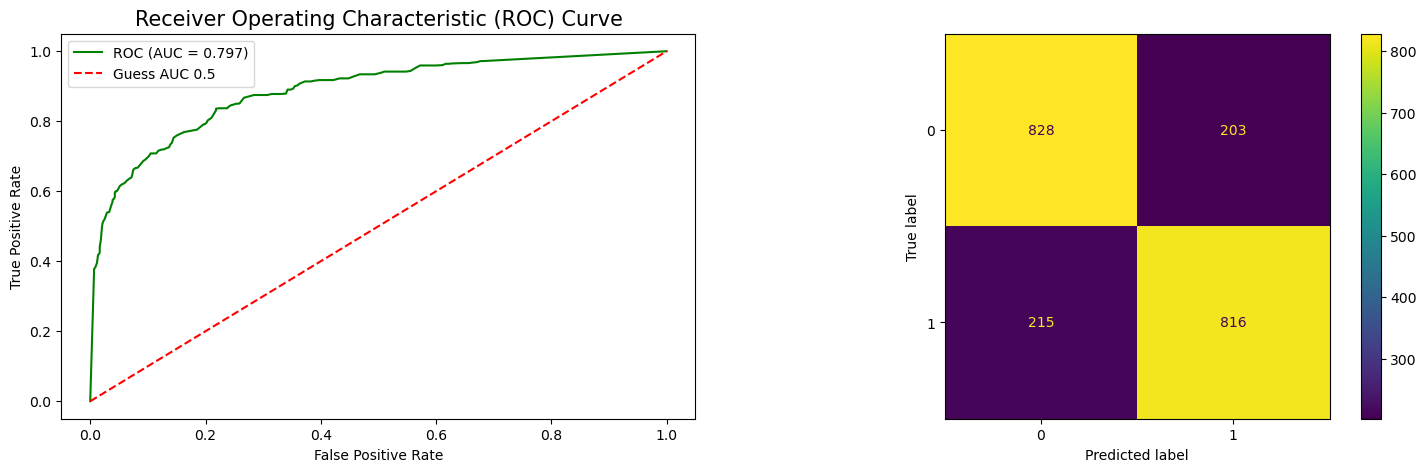

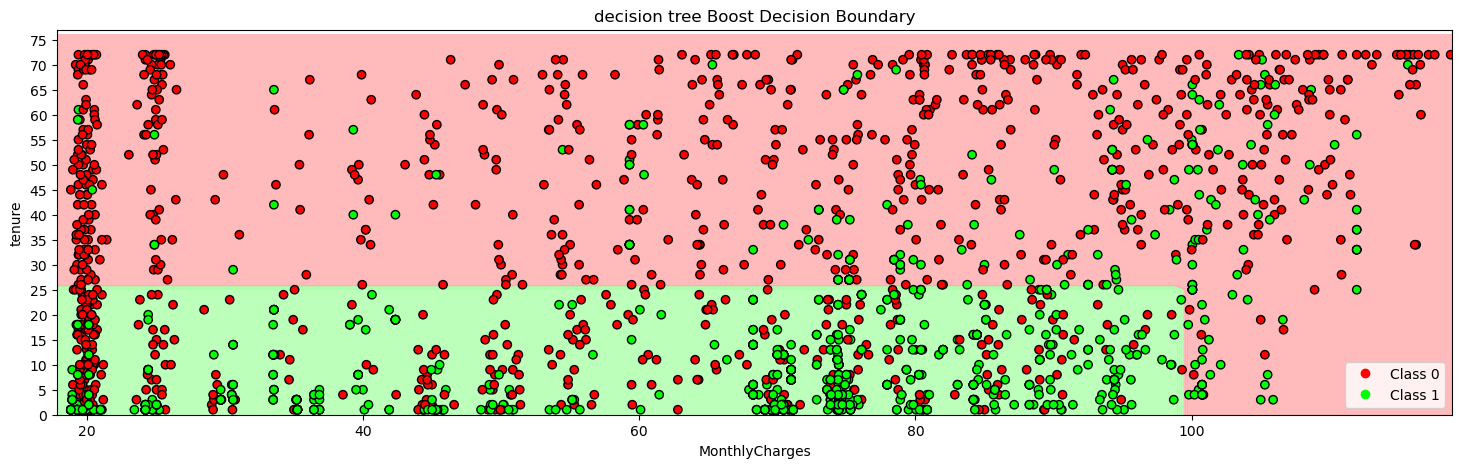

In [24]:
# Evaluation
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_validate

cv_results = cross_validate(dt_clf, X_train, y_train, cv=rskf, scoring=['recall', 'roc_auc'], n_jobs=-1, return_train_score=True, error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')

predictions_prob = cross_val_predict(dt_clf, X_test, y_test, method='predict_proba', n_jobs=-1)
predictions = [0 if x < 0.5 else 1 for x in predictions_prob[:, 1]]
roc_auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test, predictions)
coef = matthews_corrcoef(y_test, predictions)
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation: {coef}")
print("\033[4mClassification Report\033[0m\n", classification_report(y_test, predictions))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions_prob[:, 1])
plot_evaluation(fpr, tpr, y_test, predictions, roc_auc)
feature1 = 'MonthlyCharges'
feature2 = 'tenure'
decision_boundary(X_test,y_test,feature1,feature2,dt_clf,transformer=None,title="decision tree Boost")

- ### Single tree Not able to fit the data properly,Looks Underfitting We can apply ensemble techiniques to learn better

## Results
### Model Performance Summary (Day 5 - Error Analysis and Decision Tree Introduction for Churn Prediction)

#### Cross-Validation Results

* **Mean Train ROC AUC Score**: 0.9325
* **Mean Train Recall Score**: 0.8465

* **Mean Test ROC AUC Score**: 0.8909
* **Mean Test Recall Score**: 0.8164

#### Holdout Set Performance

* **Recall Score on Holdout Set**: 0.79

#### Correlation

* **Correlation**: 0.5946

#### Classification Report on Holdout Set

|               | Precision | Recall | F1-Score | Support |
|---------------|-----------|--------|----------|---------|
| **Class 0**   | 0.79      | 0.80   | 0.80     | 1031    |
| **Class 1**   | 0.80      | 0.79   | 0.80     | 1031    |
| **Accuracy**  |           | 0.80   |          | 2062    |
| **Macro Avg** | 0.80      | 0.80   | 0.80     | 2062    |
| **Weighted Avg** | 0.80   | 0.80   | 0.80     | 2062    |

#### Insights

* **Model Performance**: The decision tree model introduced after error analysis shows a high train ROC AUC score of 0.9325, but the test ROC AUC score is somewhat lower at 0.8909. This indicates the model performs very well on the training data but slightly less so on the test data, suggesting potential overfitting.

* **Recall Performance**: The mean train recall score is high at 0.8465, while the mean test recall score is 0.8164. The recall score on the holdout set has decreased to 0.79, down from the previous 0.85. This indicates the model's ability to identify churn cases has diminished somewhat after the introduction of the decision tree.

* **Precision vs. Recall Balance**: Precision and recall for both classes are balanced at 0.80, indicating that the model's ability to correctly identify both churn and non-churn cases is consistent, albeit with a slight decrease in overall performance compared to previous results.

* **Overall Accuracy**: The overall accuracy remains steady at 0.80, demonstrating that the model can still effectively distinguish between churn and non-churn cases despite the slight decrease in recall.

* **Correlation**: The correlation between predicted probabilities and actual class labels has slightly decreased to 0.5946, suggesting the relationship is not as strong as before.

#### Changes from Previous Days

* **Decreased Recall and Correlation**: Compared to Day 4, where the recall was 0.85 and the correlation was 0.6298, the current recall of 0.79 and correlation of 0.5946 indicate a decrease in performance. This suggests that the decision tree model, while performing well on training data, may not generalize as effectively to new data.
* **Balanced Precision and Recall**: Despite the decrease in recall, the precision and recall balance indicates the model maintains consistency in identifying both classes.

#### Recommendations for Further Improvement

* **Model Tuning**: Fine-tune the decision tree's hyperparameters or consider pruning to reduce overfitting and improve generalization.
* **Ensemble Methods**: Consider combining the decision tree with other models in an ensemble approach (e.g., Random Forest, Gradient Boosting) to leverage the strengths of multiple models and enhance overall performance.
* **Regularization**: Apply regularization techniques to the decision tree to control for complexity and overfitting.
* **Continued Feature Engineering**: Further refine and add new features that may capture more relevant patterns for churn prediction, potentially improving recall and overall performance.
* **Error Analysis**: Conduct detailed error analysis to identify specific areas where the model underperforms and address these issues through targeted adjustments.

By focusing on these aspects, the model can potentially recover and improve, providing more accurate and reliable predictions for churn.

## Conclusion
- 79% of churners are identified with 80% precision (chance that our predicted churners are actually churners). Indicating most of our predicted churners are actual Churners